In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Ehugbo Experiments/ehugbodataset.csv").drop("Unnamed: 0", axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 14 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   Pseudo ID                                         312 non-null    int64 
 1   Age                                               312 non-null    int64 
 2   Gender                                            312 non-null    object
 3   Occupation                                        312 non-null    object
 4   Native Language                                   312 non-null    object
 5   Are you a native Ehugbo Speaker?                  312 non-null    object
 6   How Fluent are you with speaking Ehugbo?          312 non-null    int64 
 7   What is the highest level of education attained?  312 non-null    object
 8   Bible Chapter Read                                312 non-null    object
 9   Audio File Name (.wav)          

In [ ]:
!python -V

Python 3.12.12


In [ ]:
df.head(2)

,Pseudo ID,Age,Gender,Occupation,Native Language,Are you a native Ehugbo Speaker?,How Fluent are you with speaking Ehugbo?,What is the highest level of education attained?,Bible Chapter Read,Audio File Name (.wav),Transcript Link,Transcript,Audio File Link,English Translation
0,1,63,Male,Clergy,Ehugbo,Yes,5,University/ Polytechnic (Bachelor's),"Galatians Chapter 1,2, 3 vs 1-14",Galatians 1_1,https://docs.google.com/spreadsheets/d/1CMg99n...,"Ọ bụ mụoni bụ Pọl, onyeozi nke Onyenwoayị, eeh...",https://drive.google.com/file/d/1HQjokzzJOlzSl...,"Paul, an apostle—sent not from men nor by a ma..."
1,1,63,Male,Clergy,Ehugbo,Yes,5,University/ Polytechnic (Bachelor's),"Galatians Chapter 1,2, 3 vs 1-14",Galatians 1_2,https://docs.google.com/spreadsheets/d/1CMg99n...,"mụa ụmụne m na ohu na ime Karaịs mụa wo nọ, na...",https://drive.google.com/file/d/1vWFZnPDS3oAxA...,"and all the brothers and sisters with me, To t..."


In [ ]:
import os

# Define the root path
root_path = "/content/drive/MyDrive/Verse by verse work"
folders = ['Ephesians', 'Galatians', 'Acts of Apostles', 'Romans', 'Revelations', 'John']

# Create a dictionary to map filename to its actual path
file_path_map = {}

for folder in folders:
    folder_full_path = os.path.join(root_path, folder)
    if os.path.exists(folder_full_path):
        files = os.listdir(folder_full_path)
        for f in files:
            # We strip extension to match your 'Audio File Name (.wav)' column
            name_without_ext = os.path.splitext(f)[0]
            file_path_map[name_without_ext] = os.path.join(folder_full_path, f)

# Apply mapping to the dataframe
df['local_path'] = df['Audio File Name (.wav)'].map(file_path_map)

# Check if any files are missing
missing_count = df['local_path'].isna().sum()
print(f"Total rows in DF: {len(df)}")
print(f"Successfully mapped: {len(df) - missing_count}")
print(f"Missing files: {missing_count}")

if missing_count > 0:
    print("\nSample of missing filenames in the DF:")
    print(df[df['local_path'].isna()]['Audio File Name (.wav)'].head())

Total rows in DF: 312
Successfully mapped: 312
Missing files: 0


In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import librosa
import logging
import numpy as np
from sentence_transformers import util, SentenceTransformer
from transformers import AutoTokenizer, AutoModel, ClapModel, ClapProcessor
from tqdm import tqdm

# --- 1. CONFIGURATION ---
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Environment Ready. Running on: {device}")

# Storage for final leaderboard
results_summary = []

# --- 2. ROBUST UTILITIES ---

def mean_pooling(model_output, attention_mask):
    """Pools BERT/AfriBERTa token embeddings into a single sentence vector."""
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def extract_clap_tensor(output):
    """Specifically handles the complex output objects of CLAP models."""
    if hasattr(output, "text_embeds"): return output.text_embeds
    if hasattr(output, "audio_embeds"): return output.audio_embeds
    if isinstance(output, torch.Tensor): return output
    # Fallback for generic outputs: take pooled output or first token
    res = output[1] if len(output) > 1 else output[0]
    return res.squeeze(1) if res.ndim == 3 else res

def evaluate_retrieval(query_embs, doc_embs, model_name, task_type):
    """Computes Top-K Accuracy and MRR for the 1:1 Verse Retrieval Task."""
    query_embs = query_embs.to(device)
    doc_embs = doc_embs.to(device)

    # Cosine Similarity Matrix [Queries x Documents]
    cos_sim = util.cos_sim(query_embs, doc_embs)
    num_queries = cos_sim.size(0)

    ks = [1, 5, 10]
    hits = {k: 0 for k in ks}
    mrr_sum = 0.0

    for i in range(num_queries):
        target_idx = i # In this dataset, Query i matches Document i
        # Sort indices by similarity score
        sorted_indices = torch.argsort(cos_sim[i], descending=True)
        # Find the rank of the correct answer (1-indexed)
        rank = (sorted_indices == target_idx).nonzero(as_tuple=True)[0].item() + 1

        mrr_sum += (1.0 / rank)
        for k in ks:
            if rank <= k: hits[k] += 1

    results_summary.append({
        "Model": model_name,
        "Task": task_type,
        "Top-1": f"{(hits[1]/num_queries)*100:.2f}%",
        "Top-5": f"{(hits[5]/num_queries)*100:.2f}%",
        "Top-10": f"{(hits[10]/num_queries)*100:.2f}%",
        "MRR": round(mrr_sum / num_queries, 4)
    })
    print(f"✅ Completed: {model_name}")

# --- 3. EXPERIMENT 1: LaBSE (Text-to-Text Baseline) ---
def run_labse(df):
    print("\n[Exp 1] Running LaBSE Text-to-Text...")
    model = SentenceTransformer('sentence-transformers/LaBSE').to(device)
    doc_embs = model.encode(df['Transcript'].tolist(), convert_to_tensor=True, show_progress_bar=True)
    query_embs = model.encode(df['English Translation'].tolist(), convert_to_tensor=True, show_progress_bar=True)
    evaluate_retrieval(query_embs, doc_embs, "LaBSE", "Text-to-Text")

# --- 4. EXPERIMENT 2: African MLMs (AfriBERTa, Serengeti, etc.) ---
def run_mlm_benchmarks(df):
    mlm_list = [
        ("castorini/afriberta_large", "AfriBERTa"),
        ("UBC-NLP/serengeti-E250", "Serengeti")
    ]

    for model_id, name in mlm_list:
        print(f"\n[Exp 2] Running {name} Text-to-Text...")
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model = AutoModel.from_pretrained(model_id).to(device)

        def encode_batch(texts, b_size=16):
            all_embs = []
            for i in range(0, len(texts), b_size):
                batch = texts[i:i+b_size]
                inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
                with torch.no_grad():
                    out = model(**inputs)
                p_embs = mean_pooling(out, inputs['attention_mask'])
                all_embs.append(F.normalize(p_embs, p=2, dim=1))
            return torch.cat(all_embs, dim=0)

        e_embs = encode_batch(df['Transcript'].tolist())
        en_embs = encode_batch(df['English Translation'].tolist())
        evaluate_retrieval(en_embs, e_embs, name, "Text-to-Text")

# --- 5. EXPERIMENT 3: CLAP (Text-to-Audio Multimodal) ---
def run_clap(df):
    print("\n[Exp 3] Running CLAP Text-to-Audio...")
    model_id = "laion/clap-htsat-unfused"
    model = ClapModel.from_pretrained(model_id).to(device)
    processor = ClapProcessor.from_pretrained(model_id)

    # Text Encoding
    queries = df['English Translation'].tolist()
    inputs_t = processor(text=queries, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        out_t = model.get_text_features(**inputs_t)
        q_embs = extract_clap_tensor(out_t)
        # Ensure 2D [Batch, Dim]
        if q_embs.ndim == 3: q_embs = q_embs.squeeze(1)
        q_embs = F.normalize(q_embs, p=2, dim=1)

    # Audio Encoding
    audio_embs_list = []
    for path in tqdm(df['local_path'].tolist(), desc="Processing Audio"):
        try:
            y, _ = librosa.load(path, sr=48000)
            inputs_a = processor(audio=y, return_tensors="pt", sampling_rate=48000).to(device)
            with torch.no_grad():
                out_a = model.get_audio_features(**inputs_a)
                a_emb = extract_clap_tensor(out_a)
                if a_emb.ndim == 3: a_emb = a_emb.squeeze(1)
                audio_embs_list.append(F.normalize(a_emb, p=2, dim=1))
        except Exception:
            audio_embs_list.append(torch.zeros((1, q_embs.shape[1])).to(device))

    d_embs = torch.cat(audio_embs_list, dim=0)
    evaluate_retrieval(q_embs, d_embs, "CLAP", "Text-to-Audio")

# --- 6. EXECUTION ---
if 'df' in locals():
    # Run all experiments
    run_labse(df)
    run_mlm_benchmarks(df)
    run_clap(df)

    # Display Results
    print("\n" + "="*75)
    print("             EHUGBO-QA BENCHMARK: FINAL LEADERBOARD")
    print("="*75)
    final_df = pd.DataFrame(results_summary)
    print(final_df.to_string(index=False))
    print("="*75)
    print("\nAction: Copy this table into your SIGIR 2026 Proposal.")
else:
    print("❌ Error: DataFrame 'df' not found. Please load your dataset first.")

🚀 Environment Ready. Running on: cuda

[Exp 1] Running LaBSE Text-to-Text...


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.self.value.bias, embeddings.LayerNorm.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.output.dense.weight, embeddings.word_embeddings.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.bias, embeddings.position_embeddings.weight


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Completed: LaBSE

[Exp 2] Running AfriBERTa Text-to-Text...


config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.self.value.bias, embeddings.LayerNorm.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.output.dense.weight, embeddings.word_embeddings.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.bias, embeddings.position_embeddings.weight


Loading weights:   0%|          | 0/165 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/503M [00:00<?, ?B/s]

✅ Completed: AfriBERTa

[Exp 2] Running Serengeti Text-to-Text...


config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.self.value.bias, embeddings.LayerNorm.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.output.dense.weight, embeddings.word_embeddings.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.output.dense.bias, embeddings.position_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

✅ Completed: Serengeti

[Exp 3] Running CLAP Text-to-Audio...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/615M [00:00<?, ?B/s]

The following layers were not sharded: text_model.embeddings.token_type_ids, audio_model.audio_encoder.layers.*.blocks.*.intermediate.dense.weight, text_model.embeddings.position_ids, audio_model.audio_encoder.norm.bias, text_model.embeddings.LayerNorm.bias, audio_model.audio_encoder.batch_norm.num_batches_tracked, text_model.encoder.layer.*.attention.self.query.weight, audio_projection.linear2.weight, text_model.encoder.layer.*.attention.output.LayerNorm.bias, text_model.embeddings.token_type_embeddings.weight, text_model.encoder.layer.*.attention.self.value.weight, audio_model.audio_encoder.layers.*.blocks.*.attention.self.query.weight, audio_model.audio_encoder.layers.*.blocks.*.output.dense.bias, audio_model.audio_encoder.layers.*.blocks.*.attention.self.key.weight, logit_scale_t, text_projection.linear1.weight, audio_projection.linear1.bias, text_model.encoder.layer.*.attention.self.query.bias, text_model.encoder.layer.*.output.LayerNorm.bias, audio_model.audio_encoder.layers.*.bl

Loading weights:   0%|          | 0/447 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/614M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Processing Audio: 100%|██████████| 312/312 [05:41<00:00,  1.09s/it]

✅ Completed: CLAP

             EHUGBO-QA BENCHMARK: FINAL LEADERBOARD
    Model          Task  Top-1  Top-5 Top-10    MRR
    LaBSE  Text-to-Text 85.26% 95.83% 96.47% 0.8990
AfriBERTa  Text-to-Text  1.28%  9.62% 16.03% 0.0610
Serengeti  Text-to-Text  4.17%  8.97% 12.50% 0.0789
     CLAP Text-to-Audio  0.32%  2.24%  2.56% 0.0229

Action: Copy this table into your SIGIR 2026 Proposal.


Deeper Dive

In [ ]:
# We will use a subset (e.g., 200 verses) for clearer visualization
viz_df = df.head(200)
eh_list = viz_df['Transcript'].tolist()
en_list = viz_df['English Translation'].tolist()

# 1. LaBSE
print("Extracting LaBSE...")
labse_model = SentenceTransformer('sentence-transformers/LaBSE').to(device)
labse_eh = labse_model.encode(eh_list, convert_to_tensor=True)
labse_en = labse_model.encode(en_list, convert_to_tensor=True)

# Helper for MLM extraction
def get_mlm_vecs(model_id):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModel.from_pretrained(model_id).to(device)
    def enc(texts):
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            out = model(**inputs)
        return F.normalize(mean_pooling(out, inputs['attention_mask']), p=2, dim=1)
    return enc(en_list), enc(eh_list)

# 2. Serengeti
print("Extracting Serengeti...")
ser_en, ser_eh = get_mlm_vecs("UBC-NLP/serengeti-E250")

# 3. Afro-XLMR
print("Extracting Afro-XLMR...")
afro_xlmr_en, afro_xlmr_eh = get_mlm_vecs("Davlan/afro-xlmr-base")

# 4. AfriBERTa
print("Extracting AfriBERTa...")
afriberta_en, afriberta_eh = get_mlm_vecs("castorini/afriberta_large")

Extracting LaBSE...


The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.self.value.bias, embeddings.LayerNorm.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.output.dense.weight, embeddings.word_embeddings.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.bias, embeddings.position_embeddings.weight


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Extracting Serengeti...


The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.self.value.bias, embeddings.LayerNorm.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.output.dense.weight, embeddings.word_embeddings.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.output.dense.bias, embeddings.position_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

Extracting Afro-XLMR...


config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.self.value.bias, embeddings.LayerNorm.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.output.dense.weight, embeddings.word_embeddings.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.bias, embeddings.position_embeddings.weight


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

Extracting AfriBERTa...


The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.self.value.bias, embeddings.LayerNorm.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.output.dense.weight, embeddings.word_embeddings.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.output.LayerNorm.bias, pooler.dense.weight, encoder.layer.*.attention.self.value.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.attention.output.dense.bias, pooler.dense.bias, embeddings.position_embeddings.weight


Loading weights:   0%|          | 0/165 [00:00<?, ?it/s]

In [ ]:
# 5. CLAP (Multimodal)
print("Extracting CLAP (Text-to-Audio)...")
clap_model_id = "laion/clap-htsat-unfused"
clap_model = ClapModel.from_pretrained(clap_model_id).to(device)
clap_proc = ClapProcessor.from_pretrained(clap_model_id)

# 5a. English Text Queries
inputs_t = clap_proc(text=en_list, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    out_t = clap_model.get_text_features(**inputs_t)

    # --- RIGOROUS EXTRACTION ---
    if hasattr(out_t, 'text_embeds'):
        clap_en = out_t.text_embeds
    elif hasattr(out_t, 'pooler_output'):
        clap_en = out_t.pooler_output
    elif isinstance(out_t, torch.Tensor):
        clap_en = out_t
    else:
        # Fallback: take the first item of the output
        clap_en = out_t[0]

    # Now that we DEFINITELY have a tensor, check dimensions
    if clap_en.ndim == 3:
        clap_en = clap_en.squeeze(1)

    clap_en = F.normalize(clap_en, p=2, dim=1)
    print(f"Final Query Tensor Shape: {clap_en.shape}")

# 5b. Ehugbo Audio Clips
clap_eh_list = []
for path in tqdm(viz_df['local_path'].tolist(), desc="CLAP Audio"):
    try:
        y, _ = librosa.load(path, sr=48000)
        inputs_a = clap_proc(audio=y, return_tensors="pt", sampling_rate=48000).to(device)
        with torch.no_grad():
            out_a = clap_model.get_audio_features(**inputs_a)

            # --- RIGOROUS EXTRACTION ---
            if hasattr(out_a, 'audio_embeds'):
                a_emb = out_a.audio_embeds
            elif hasattr(out_a, 'pooler_output'):
                a_emb = out_a.pooler_output
            elif isinstance(out_a, torch.Tensor):
                a_emb = out_a
            else:
                a_emb = out_a[0]

            if a_emb.ndim == 3:
                a_emb = a_emb.squeeze(1)

            clap_eh_list.append(F.normalize(a_emb, p=2, dim=1))
    except Exception as e:
        print(f"Failed to process {path}: {e}")
        clap_eh_list.append(torch.zeros((1, 512)).to(device))

clap_eh = torch.cat(clap_eh_list, dim=0)
print(f"Final Audio Tensor Shape: {clap_eh.shape}")

Extracting CLAP (Text-to-Audio)...


The following layers were not sharded: text_model.embeddings.token_type_ids, audio_model.audio_encoder.layers.*.blocks.*.intermediate.dense.weight, text_model.embeddings.position_ids, audio_model.audio_encoder.norm.bias, text_model.embeddings.LayerNorm.bias, audio_model.audio_encoder.batch_norm.num_batches_tracked, text_model.encoder.layer.*.attention.self.query.weight, audio_projection.linear2.weight, text_model.encoder.layer.*.attention.output.LayerNorm.bias, text_model.embeddings.token_type_embeddings.weight, text_model.encoder.layer.*.attention.self.value.weight, audio_model.audio_encoder.layers.*.blocks.*.attention.self.query.weight, audio_model.audio_encoder.layers.*.blocks.*.output.dense.bias, audio_model.audio_encoder.layers.*.blocks.*.attention.self.key.weight, logit_scale_t, text_projection.linear1.weight, audio_projection.linear1.bias, text_model.encoder.layer.*.attention.self.query.bias, text_model.encoder.layer.*.output.LayerNorm.bias, audio_model.audio_encoder.layers.*.bl

Loading weights:   0%|          | 0/447 [00:00<?, ?it/s]

Final Query Tensor Shape: torch.Size([200, 512])


CLAP Audio: 100%|██████████| 200/200 [00:25<00:00,  7.74it/s]

Final Audio Tensor Shape: torch.Size([200, 512])


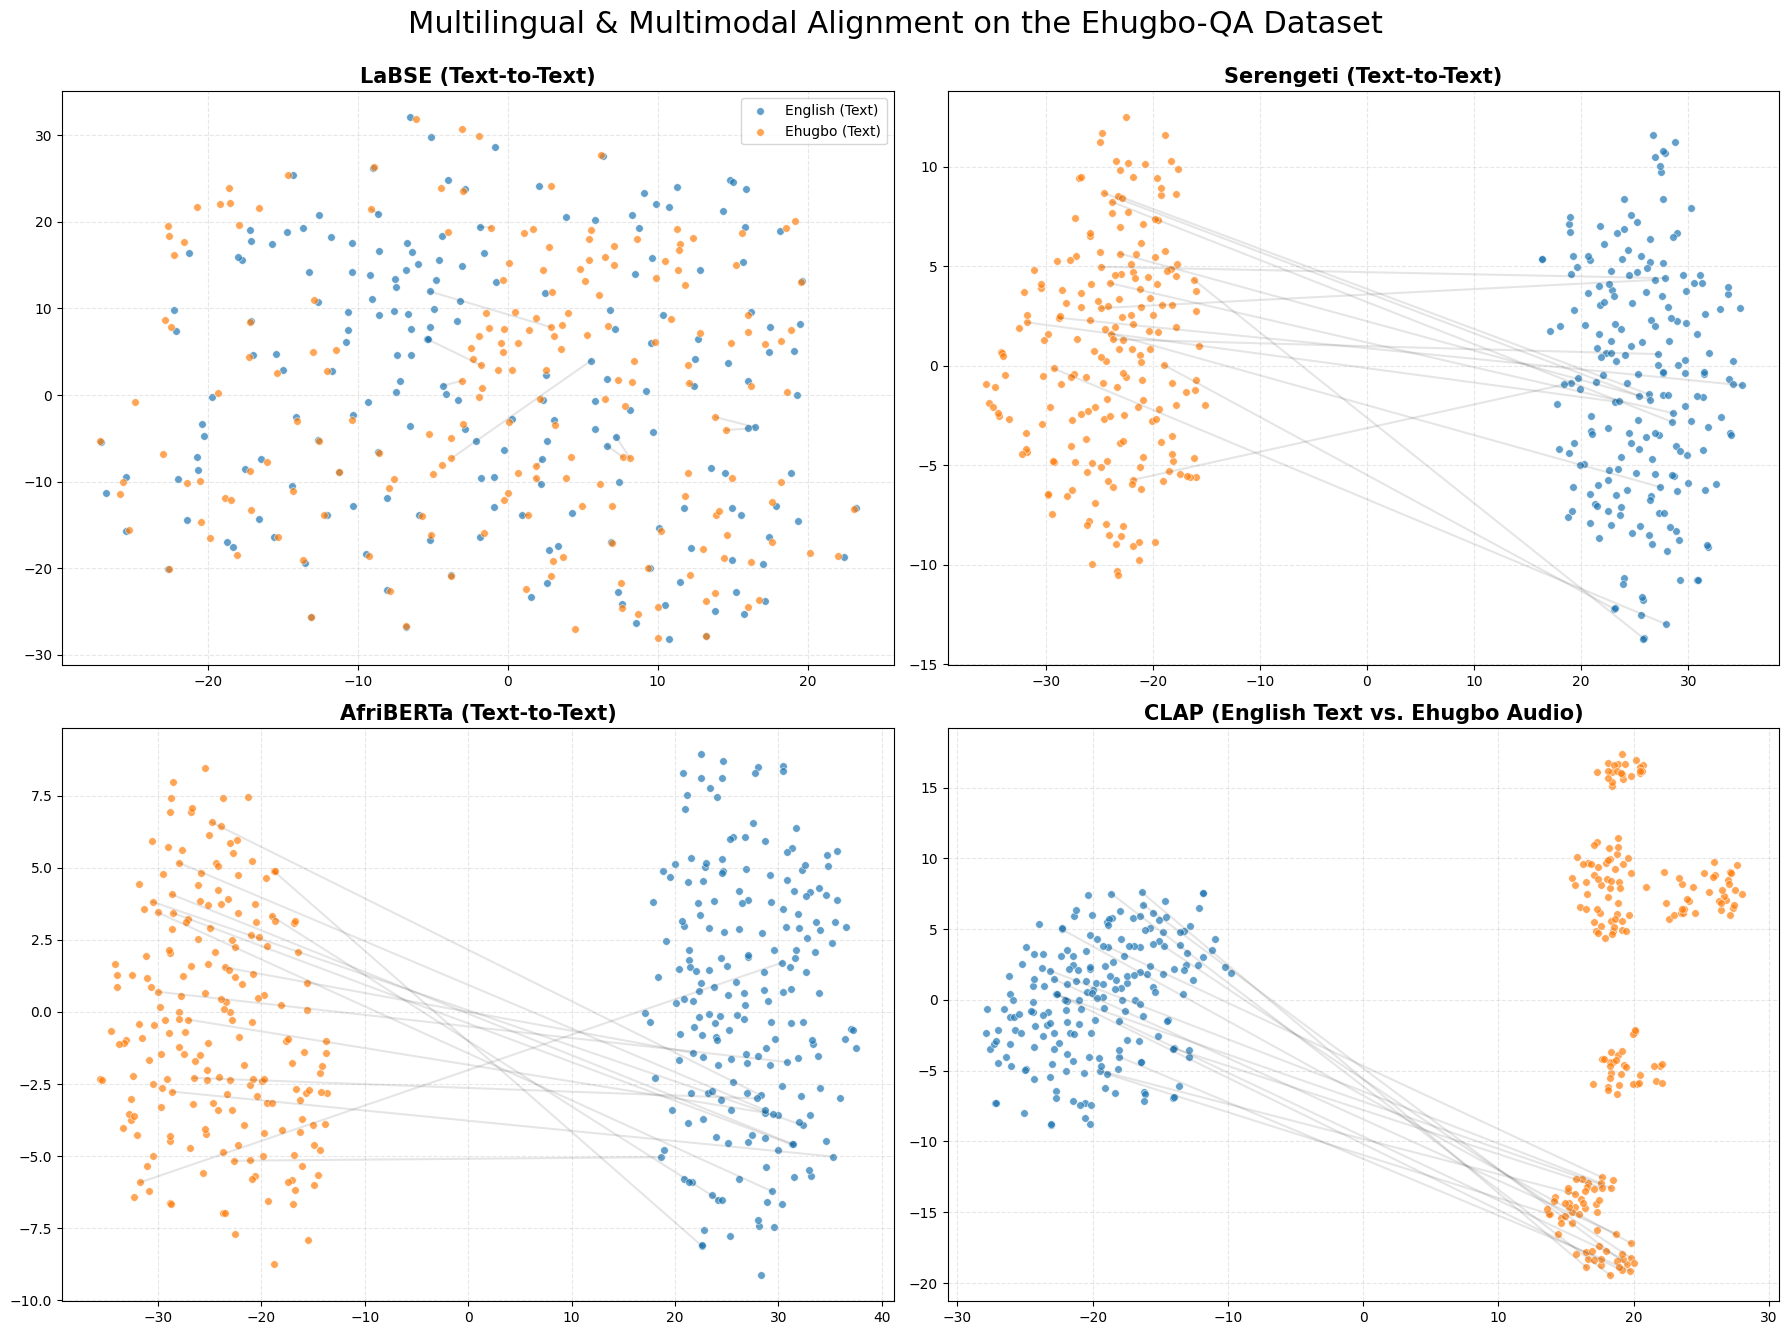

In [ ]:
# Add CLAP to the comparison list
models_to_plot = [
    (labse_en, labse_eh, "LaBSE (Text-to-Text)"),
    (ser_en, ser_eh, "Serengeti (Text-to-Text)"),
    (afriberta_en, afriberta_eh, "AfriBERTa (Text-to-Text)"),
    (clap_en, clap_eh, "CLAP (English Text vs. Ehugbo Audio)")
]

fig, axes = plt.subplots(2, 2, figsize=(18, 14)) # 2x2 grid
axes = axes.flatten()

for i, (en_vecs, target_vecs, title) in enumerate(models_to_plot):
    X = torch.cat([en_vecs, target_vecs], dim=0).detach().cpu().numpy()

    # Perplexity 30 is usually good for 200-400 points
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
    X_2d = tsne.fit_transform(X)

    mid = len(en_vecs)

    # Plot English (Queries)
    axes[i].scatter(X_2d[:mid, 0], X_2d[:mid, 1], label='English (Text)', alpha=0.7, s=30, color='#1f77b4', edgecolors='white', linewidth=0.5)

    # Plot Ehugbo (Audio for CLAP, Text for others)
    label_name = 'Ehugbo (Audio)' if "CLAP" in title else 'Ehugbo (Text)'
    axes[i].scatter(X_2d[mid:, 0], X_2d[mid:, 1], label=label_name, alpha=0.7, s=30, color='#ff7f0e', edgecolors='white', linewidth=0.5)

    # Draw alignment lines for the first 15 pairs to show the "mapping"
    for j in range(0, 15):
        axes[i].plot([X_2d[j, 0], X_2d[mid+j, 0]], [X_2d[j, 1], X_2d[mid+j, 1]], color='black', alpha=0.1, linestyle='-')

    axes[i].set_title(title, fontsize=15, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.3)
    if i == 0: axes[i].legend(loc='upper right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Multilingual & Multimodal Alignment on the Ehugbo-QA Dataset", fontsize=22, y=.98)
plt.show()

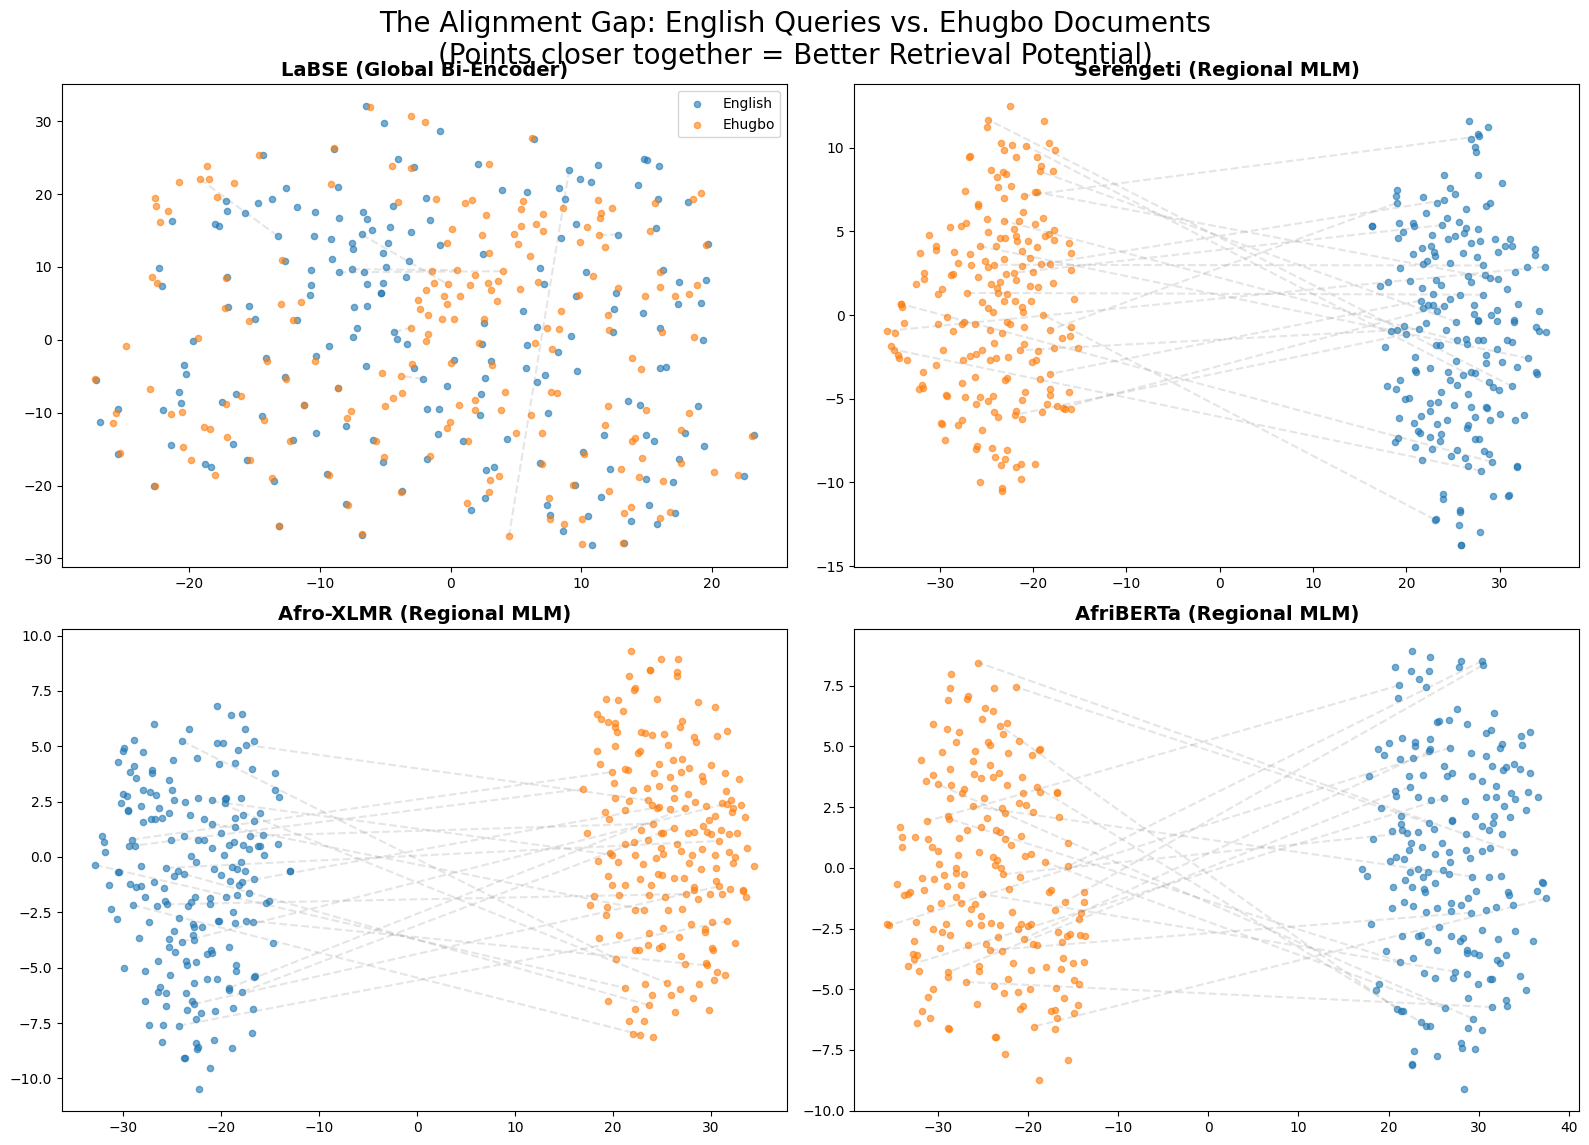

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Now the names are defined in the global scope
models_to_plot = [
    (labse_en, labse_eh, "LaBSE (Global Bi-Encoder)"),
    (ser_en, ser_eh, "Serengeti (Regional MLM)"),
    (afro_xlmr_en, afro_xlmr_eh, "Afro-XLMR (Regional MLM)"),
    (afriberta_en, afriberta_eh, "AfriBERTa (Regional MLM)")
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (en_vecs, eh_vecs, title) in enumerate(models_to_plot):
    # Move to CPU and convert to numpy for sklearn
    X = torch.cat([en_vecs, eh_vecs], dim=0).detach().cpu().numpy()

    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_2d = tsne.fit_transform(X)

    mid = len(en_vecs)

    # Plot English points
    axes[i].scatter(X_2d[:mid, 0], X_2d[:mid, 1],
                    label='English', alpha=0.6, s=20, color='#1f77b4')

    # Plot Ehugbo points
    axes[i].scatter(X_2d[mid:, 0], X_2d[mid:, 1],
                    label='Ehugbo', alpha=0.6, s=20, color='#ff7f0e')

    # Optional: Draw lines between the same verse to show "Alignment Gap"
    # This visually demonstrates the IR challenge
    for j in range(0, mid, 10): # Draw for every 10th verse to avoid clutter
        axes[i].plot([X_2d[j, 0], X_2d[mid+j, 0]],
                     [X_2d[j, 1], X_2d[mid+j, 1]],
                     color='gray', linestyle='--', alpha=0.2)

    axes[i].set_title(title, fontsize=14, fontweight='bold')
    if i == 0: axes[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("The Alignment Gap: English Queries vs. Ehugbo Documents\n(Points closer together = Better Retrieval Potential)",
             fontsize=20, y=0.98)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

# 1. SETUP MODELS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
en_queries = df['English Translation'].tolist()
eh_transcripts = df['Transcript'].tolist()

# 2. GENERATE AND SAVE VECTORS
print("Saving LaBSE vectors...")
labse = SentenceTransformer('sentence-transformers/LaBSE').to(device)
labse_en = labse.encode(en_queries, convert_to_tensor=True)
labse_eh = labse.encode(eh_transcripts, convert_to_tensor=True)

print("Saving Serengeti vectors...")
ser_tok = AutoTokenizer.from_pretrained("UBC-NLP/serengeti-E250")
ser_mod = AutoModel.from_pretrained("UBC-NLP/serengeti-E250").to(device)

def get_ser_embs(texts):
    inputs = ser_tok(texts, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        out = ser_mod(**inputs)
    # Mean pooling
    mask = inputs['attention_mask'].unsqueeze(-1).expand(out[0].size()).float()
    embs = torch.sum(out[0] * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)
    return F.normalize(embs, p=2, dim=1)

ser_en = get_ser_embs(en_queries)
ser_eh = get_ser_embs(eh_transcripts)

# 3. TOKENIZATION INVESTIGATION
print("\n--- TOKENIZATION ANALYSIS ---")
def count_tokens(texts, tokenizer):
    counts = [len(tokenizer.tokenize(t)) for t in texts]
    return np.mean(counts)

avg_labse = count_tokens(eh_transcripts, labse.tokenizer)
avg_ser = count_tokens(eh_transcripts, ser_tok)

print(f"Ehugbo Mean Tokens (LaBSE): {avg_labse:.2f}")
print(f"Ehugbo Mean Tokens (Serengeti): {avg_ser:.2f}")

Saving LaBSE vectors...
Saving Serengeti vectors...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



--- TOKENIZATION ANALYSIS ---
Ehugbo Mean Tokens (LaBSE): 47.44
Ehugbo Mean Tokens (Serengeti): 39.52


Plotting LaBSE Alignment...


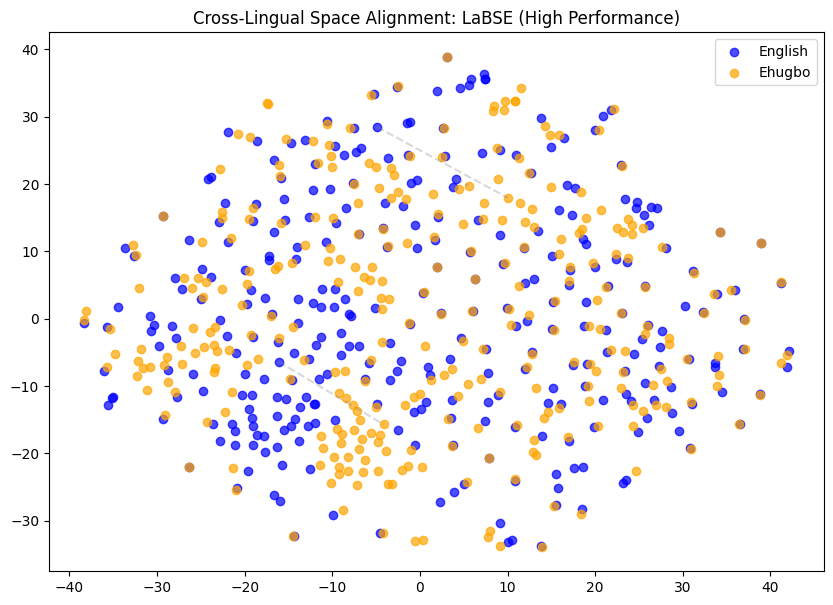

Plotting Serengeti Alignment...


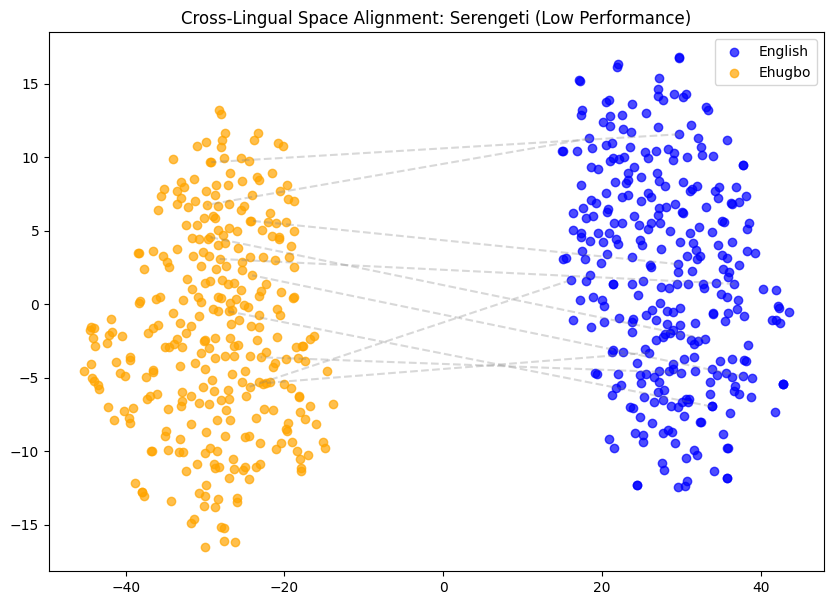

In [ ]:
def plot_tsne(en_vecs, eh_vecs, title):
    # Prepare data
    X = torch.cat([en_vecs, eh_vecs], dim=0).cpu().numpy()
    labels = ['English'] * len(en_vecs) + ['Ehugbo'] * len(eh_vecs)

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_embedded = tsne.fit_transform(X)

    # Plot
    plt.figure(figsize=(10, 7))
    plt.scatter(X_embedded[:len(en_vecs), 0], X_embedded[:len(en_vecs), 1], label='English', alpha=0.7, c='blue')
    plt.scatter(X_embedded[len(en_vecs):, 0], X_embedded[len(en_vecs):, 1], label='Ehugbo', alpha=0.7, c='orange')

    # Draw lines between 10 random pairs to show "distance"
    for i in range(10):
        idx = np.random.randint(0, len(en_vecs))
        plt.plot([X_embedded[idx, 0], X_embedded[idx+len(en_vecs), 0]],
                 [X_embedded[idx, 1], X_embedded[idx+len(en_vecs), 1]], 'gray', linestyle='--', alpha=0.3)

    plt.title(f"Cross-Lingual Space Alignment: {title}")
    plt.legend()
    plt.show()

print("Plotting LaBSE Alignment...")
plot_tsne(labse_en, labse_eh, "LaBSE (High Performance)")

print("Plotting Serengeti Alignment...")
plot_tsne(ser_en, ser_eh, "Serengeti (Low Performance)")

In [ ]:
from sentence_transformers import util

def get_failures(en_vecs, eh_vecs, df, model_name, top_n=3):
    # Calculate similarity
    sim_matrix = util.cos_sim(en_vecs, eh_vecs)

    failures = []
    for i in range(len(df)):
        # Find the index of the highest similarity score
        best_match_idx = torch.argmax(sim_matrix[i]).item()

        # If the best match is NOT the correct index (i)
        if best_match_idx != i:
            failures.append({
                'Model': model_name,
                'English Query': df['English Translation'].iloc[i][:100] + "...",
                'Correct Ehugbo': df['Transcript'].iloc[i][:100] + "...",
                'AI Predicted Ehugbo': df['Transcript'].iloc[best_match_idx][:100] + "...",
                'AI_Confidence': f"{sim_matrix[i][best_match_idx].item():.4f}"
            })

    # Sort by how "confident" the AI was in its mistake
    fail_df = pd.DataFrame(failures).sort_values(by='AI_Confidence', ascending=False)
    return fail_df.head(top_n)

# 1. Analyze LaBSE's rare mistakes
print("Analyzing LaBSE's most confident errors...")
labse_fails = get_failures(labse_en, labse_eh, df, "LaBSE")

# 2. Analyze Serengeti's common mistakes
print("Analyzing Serengeti's most confident errors...")
serengeti_fails = get_failures(ser_en, ser_eh, df, "Serengeti")

# Combine and show
error_report = pd.concat([labse_fails, serengeti_fails])
error_report

Analyzing LaBSE's most confident errors...
Analyzing Serengeti's most confident errors...


,Model,English Query,Correct Ehugbo,AI Predicted Ehugbo,AI_Confidence
16,LaBSE,Praise be to the God and Father of our Lord Je...,Na otuto dịrị Chineke bụ Nna nke Onyenwoayị Ji...,Ihe m na-arịa mgbe ọọbụla bụ na Chineke nke On...,0.5983
45,LaBSE,"Whoever has ears, let them hear what the Spiri...","Onye nwo ntị, ya ọ nụụ ihe Maa Nsọ na-ekwuru n...","Onye nwo ntị, ya ọ nụụ ihe Maa Nsọ na-ekwuru n...",0.5836
44,LaBSE,"Whoever has ears, let them hear what the Spiri...","“Onye nwo ntị, ya ọ nụụ ihe Maa Nsọ na-ekwuru ...","Onye nwo ntị, ya ọ nụụ ihe Maa Nsọ na-ekwuru n...",0.5836
43,Serengeti,"I do not set aside the grace of God, for if ri...",Esogu m ndem na-eme ẹwụọma Chineke ka a sị na ...,"Jọn sị wo, “Eji m mini na-eme baụtizim, ọ bụ n...",0.9479
33,Serengeti,"When Peter came to Antioch, I opposed him to h...","Mgbe Pita bịarị na Antịọk, m guzogidie ihu la ...","Jọn sị wo, “Eji m mini na-eme baụtizim, ọ bụ n...",0.9469
193,Serengeti,"to take over this apostolic ministry, which Ju...","je-anọchi ọnọdụ dịka onyeozi nke Onyenwoayị, J...","Ahụwo mu e, na-agba ama na ọ bụ a bụ Ọkpara Ch...",0.9446


In [ ]:
# 1. Create a deduplicated version of the dataframe
# We keep only unique English Translations to ensure variety
df_unique = df.drop_duplicates(subset=['English Translation']).copy()

# 2. Shuffle the dataframe randomly
# 'frac=1' shuffles the whole thing, 'random_state=42' ensures you can reproduce results
df_random = df_unique.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original rows: {len(df)}")
print(f"Unique, randomized rows: {len(df_random)}")

# 3. Regenerate unique embeddings for this new randomized set
print("\nRegenerating embeddings for randomized unique set...")
# (Using LaBSE as the example, but repeat for Serengeti if needed)
labse_en_rand = labse_model.encode(df_random['English Translation'].tolist(), convert_to_tensor=True)
labse_eh_rand = labse_model.encode(df_random['Transcript'].tolist(), convert_to_tensor=True)

ser_en_rand = get_ser_embs(df_random['English Translation'].tolist())
ser_eh_rand = get_ser_embs(df_random['Transcript'].tolist())

Original rows: 312
Unique, randomized rows: 310

Regenerating embeddings for randomized unique set...


In [ ]:
def get_failures_random(en_vecs, eh_vecs, dataframe, model_name, top_n=5):
    sim_matrix = util.cos_sim(en_vecs, eh_vecs)
    failures = []

    for i in range(len(dataframe)):
        best_match_idx = torch.argmax(sim_matrix[i]).item()
        if best_match_idx != i:
            failures.append({
                'Model': model_name,
                'Query': dataframe['English Translation'].iloc[i][:100],
                'Correct': dataframe['Transcript'].iloc[i][:100],
                'Predicted': dataframe['Transcript'].iloc[best_match_idx][:100],
                'Confidence': f"{sim_matrix[i][best_match_idx].item():.4f}"
            })

    return pd.DataFrame(failures).sort_values(by='Confidence', ascending=False).head(top_n)

# Run Analysis
labse_fails_rand = get_failures_random(labse_en_rand, labse_eh_rand, df_random, "LaBSE")
serengeti_fails_rand = get_failures_random(ser_en_rand, ser_eh_rand, df_random, "Serengeti")

print("\n--- Randomized Failure Analysis (Unique Queries Only) ---")
pd.concat([labse_fails_rand, serengeti_fails_rand])


--- Randomized Failure Analysis (Unique Queries Only) ---


,Model,Query,Correct,Predicted,Confidence
8,LaBSE,Praise be to the God and Father of our Lord Je...,Na otuto dịrị Chineke bụ Nna nke Onyenwoayị Ji...,Ihe m na-arịa mgbe ọọbụla bụ na Chineke nke On...,0.5983
20,LaBSE,Grace and peace to you from God our Father and...,Ekpere m bụ na ẹwụọma yaa udo nke Onyenwoayị J...,Ihe m na-arịa mgbe ọọbụla bụ na Chineke nke On...,0.5392
43,LaBSE,"For it is by grace you have been saved, throug...",Maka na ọ bụ ẹwụọma Chineke meri a zọfụta ayị ...,Unu bụkọ nde e tiyekoworu na ndeke Chineke ẹka...,0.5344
22,LaBSE,"They exchanged the truth about God for a lie, ...",Wo tụgarịa eziokwu ihe oohu bayeri Chineke wer...,bụkwanụ yaa Maa Nsọm bụ onye mkpalẹka igusi na...,0.5335
11,LaBSE,since what may be known about God is plain to ...,Iwe-ọkụ Chineke na adakwasị wo maka na o gusit...,"Maka na ayị bụ ọrụ ẹka Chineke, nde e kegeriwo...",0.5233
217,Serengeti,"I do not set aside the grace of God, for if ri...",Esogu m ndem na-eme ẹwụọma Chineke ka a sị na ...,"Jọn sị wo, “Eji m mini na-eme baụtizim, ọ bụ n...",0.9479
254,Serengeti,"When Peter came to Antioch, I opposed him to h...","Mgbe Pita bịarị na Antịọk, m guzogidie ihu la ...","Jọn sị wo, “Eji m mini na-eme baụtizim, ọ bụ n...",0.9469
65,Serengeti,"to take over this apostolic ministry, which Ju...","je-anọchi ọnọdụ dịka onyeozi nke Onyenwoayị, J...","Ahụwo mu e, na-agba ama na ọ bụ a bụ Ọkpara Ch...",0.9446
236,Serengeti,beginning from John’s baptism to the time when...,Hiteri na mgbem Jọn maliteri ejem-ozi nke baụt...,"Jọn sị wo, “Eji m mini na-eme baụtizim, ọ bụ n...",0.9442
77,Serengeti,I know your afflictions and your poverty—yet y...,"Amaworu m na ọ dịgị nke ọ ha uunu, ta marị ihe...","Chineke ọ nịrị unu Maa Nsọ a, na-arụ ọrụ ahụma...",0.9437
